# Embeddings Necronomicon
Building intuition for the embeddings layer of neural networks

## Skip-gram by hand
It's a one layer NN trained on natural text. Given one word predict the (#context_size) words to its left and right, e.g:
- given a training text: `kings wear crowns of jewels`
- and a context_size: `2`,
```
---------------+------------------------+----------------------
given the word | guess the left context | and the right context
---------------+------------------------+----------------------
'kings'       -> [                        'wear',     'crown']
'wear'        -> ['kings',                'crowns',   'of']
'crowns'      -> ['kings', 'wear',        'of',       'jewels']
'of'          -> ['wear', 'crowns',       'jewels']
'jewels'      -> ['crowns', 'of']
```

### setup

In [229]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# hyperparameters
threshold = 10
context_size = 5 # how many words on each side
n_embd = 96
batch_size = 256
learning_rate = 1e-4
max_iters = 50000
eval_interval = 500
eval_iters = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

butchering_length = context_size # how many words to keep around my special topics

In [5]:
# read another dataset
# http://mattmahoney.net/dc/textdata.html

with open('text8', 'r') as f:
    text = f.read()

print(f'{len(text)=}')
print(f'{len(text.split())=}')
print(f'alphabet = "{"".join(sorted(set(text)))}"')

vocab = list(set(text.split()))
print(f'{vocab[:10]=}')
print(f'{len(vocab)=}')

len(text)=100000000
len(text.split())=17005207
alphabet = " abcdefghijklmnopqrstuvwxyz"
vocab[:10]=['chairmanships', 'fugees', 'philodemus', 'hessdalen', 'akatsuki', 'delimitative', 'overthrows', 'scheiner', 'dabbled', 'wethers']
len(vocab)=253854


In [6]:
# how crappy is my dataset ? :(
from collections import Counter

# looking at the sorted vocab give me very low confidence in the dataset quality
print(f'{sorted(vocab)[:100]=}')
cs = Counter(text.split())
print(f'{cs.most_common(100)=}')
print(f'{cs["aaaaaacceglllnorst"]=}')

# lots of words are only mentioned once
ccs = Counter(cs.values())
print(ccs.most_common(10))

# on the plus side 'queen' and 'king' seem well represented
print(f'{cs["king"]=} {cs["queen"]=}')


sorted(vocab)[:100]=['a', 'aa', 'aaa', 'aaaa', 'aaaaaacceglllnorst', 'aaaaaaccegllnorrst', 'aaaaaah', 'aaaaaalmrsstt', 'aaaaaannrstyy', 'aaaaabbcdrr', 'aaaaargh', 'aaaargh', 'aaaassembly', 'aaab', 'aaabbbccc', 'aaahh', 'aaai', 'aaake', 'aaan', 'aaargh', 'aaas', 'aaate', 'aab', 'aababb', 'aabach', 'aabba', 'aabbcc', 'aabbirem', 'aabebwuvev', 'aabehlpt', 'aabmup', 'aabre', 'aabybro', 'aac', 'aaca', 'aacca', 'aaccording', 'aachen', 'aachener', 'aachtopf', 'aaci', 'aacis', 'aacisuan', 'aacplus', 'aacr', 'aacs', 'aacvd', 'aad', 'aadgad', 'aadl', 'aadlik', 'aadnani', 'aadvantage', 'aadyam', 'aaemu', 'aaf', 'aafc', 'aafjes', 'aafk', 'aafp', 'aag', 'aagaard', 'aagama', 'aagard', 'aage', 'aagesen', 'aagsin', 'aah', 'aahaaram', 'aahc', 'aahe', 'aahl', 'aahz', 'aai', 'aaib', 'aaiieee', 'aaimmah', 'aairpass', 'aaiun', 'aaiyangar', 'aaj', 'aajker', 'aak', 'aakirkeby', 'aakjaer', 'aakkram', 'aal', 'aalberg', 'aalborg', 'aalborghus', 'aalborgt', 'aalcc', 'aale', 'aalen', 'aalens', 'aalesund', 'aalesu

In [7]:
# let's butcher the dataset ¯\_(ツ)_/¯
# remove all the words that are only mentioned bellow a threshold
butchered_vocab = [w for w, c in cs.items() if c >= threshold]
butchered_vocab_s = set(butchered_vocab)
butchered_text = [w for w in text.split() if w in butchered_vocab_s]

print(f'{len(butchered_vocab)=}')
print(f'{len(butchered_text)=}')

len(butchered_vocab)=47134
len(butchered_text)=16561031


In [224]:
# still doesn't work, second round of butchering ¯\_(ツ)_/¯
# new idea, keep the context around the words I care about learning, and trash the rest of the dataset

words_i_want_to_learn = [
    'red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink',
    'king', 'queen', 'prince', 'princess', 'duke', 'lord', 'lady', 'sir', 'man', 'woman', 'male', 'female',
    'fruit', 'apple', 'orange', 'banana',
    'dog', 'cat', 'horse', 'cow', 'chicken', 'bird', 'fish', 'sheep', 'elephant',
    #'paris', 'london', 'madrid', 'beijing', 'tokyo', 'moscow', 'berlin', 'rome', 'washington', 'brussels', 'jerusalem', 'amsterdam', 'vienna', 'geneva' 
]

# words I wanted but they are kinda rare in my dataset:
# ['lemon', 'lime', 'watermelon', 'clementine', 'tangerine', 'madam', 'mango', 'strawberry', 'pear', 'coconut', 'kiwi', 'duchess', 'grape',]

for ct, w in sorted([(cs[w], w) for w in words_i_want_to_learn])[:5]:
    print(f'{w=}: {ct=}')

topics_whitelist = set(words_i_want_to_learn)
butchered_sentences2 = []
for i in range(butchering_length, len(butchered_text) - butchering_length):
    w = butchered_text[i]
    if w in topics_whitelist:
        butchered_sentences2.append(butchered_text[i - butchering_length: i + butchering_length + 1])

butchered_text2 = [w for s in butchered_sentences2 for w in s]
butchered_vocab2 = sorted(set(butchered_text2))

print(butchered_sentences2[:3])
print(f'{len(butchered_text)=} {len(butchered_text2)=}')
print(f'{len(butchered_vocab)=} {len(butchered_vocab2)=}')


w='banana': ct=111
w='chicken': ct=241
w='pink': ct=249
w='purple': ct=267
w='sheep': ct=305
[['greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy'], ['they', 'held', 'that', 'the', 'good', 'man', 'will', 'be', 'guided', 'at', 'every'], ['that', 'warren', 'was', 'the', 'first', 'man', 'to', 'expound', 'and', 'formulate', 'the']]
len(butchered_text)=16561031 len(butchered_text2)=534039
len(butchered_vocab)=47134 len(butchered_vocab2)=25518


In [225]:
# encode/decode helpers
vocab_size = len(butchered_vocab2)
stoi = {w: i for i, w in enumerate(butchered_vocab2)}
itos = {i: w for w, i in stoi.items()}

def encode(ws):
    return torch.tensor([stoi[w] for w in ws], dtype=torch.long)

def decode(t):
    t = t.tolist() if isinstance(t, torch.Tensor) else t
    t = [t] if isinstance(t, int) else t
    return ' '.join([itos[i] for i in t])

for xs in ['kings queens and fruits', 'white chicken black horse or brown cow']:
    print(f'{encode(xs.split())=}')
    print(f'{decode(encode(xs.split()))=}')

encode(xs.split())=tensor([12895, 18713,   975,  9438])
decode(encode(xs.split()))='kings queens and fruits'
encode(xs.split())=tensor([24989,  4145,  2648, 11175, 16512,  3187,  5497])
decode(encode(xs.split()))='white chicken black horse or brown cow'


In [10]:
# shape the data for training
# using the skip-gram method
def chunk(ws):
    x, y = [], []
    # miss a few words at the beginning and end of the text, w/e
    for i in range(context_size, len(ws) - context_size):
        x.append(ws[i])
        # TODO: here a possible optimization would be to probabilistically discard some of the most common words
        # the paper suggest proba to keep the word as:
        # $P(w_i) = ({\sqrt {z(w_i) \over 0.001} + 1}) . {0.001 \over z(w_i)}$
        # z(w_i) being the frequency of the word in the corpus
        y.append(torch.cat((ws[i - context_size: i], ws[i + 1: i + 1 + context_size])))
    return torch.tensor(x).view(-1, 1), torch.stack(y)

X, Y = chunk(encode(butchered_text2))
print(X.shape, Y.shape)

for i in range(3):
    print(X[i], Y[i])
    print(f'{decode(X[i])=} {decode(Y[i])=}')

torch.Size([534029, 1]) torch.Size([534029, 10])
tensor([12889]) tensor([10181, 25152,  1355, 20073,  4151,   952,  1506,     0, 17792, 17428])
decode(X[i])='king' decode(Y[i])='greek without archons ruler chief anarchism as a political philosophy'
tensor([952]) tensor([25152,  1355, 20073,  4151, 12889,  1506,     0, 17792, 17428, 23097])
decode(X[i])='anarchism' decode(Y[i])='without archons ruler chief king as a political philosophy they'
tensor([1506]) tensor([ 1355, 20073,  4151, 12889,   952,     0, 17792, 17428, 23097, 10757])
decode(X[i])='as' decode(Y[i])='archons ruler chief king anarchism a political philosophy they held'


In [11]:
def get_batch():
    ix = torch.randint(len(X), (batch_size,))
    x, y = X[ix], Y[ix]
    x, y = x.to(device), y.to(device)
    return x, y

xb, yb = get_batch()
print(xb[:2])
print(yb[:2])
print(f'{decode(xb[0])} -> {decode(yb[0])}')
print(f'{decode(xb[1])} -> {decode(yb[1])}')

tensor([[  975],
        [11389]], device='cuda:0')
tensor([[ 9166,   975, 25143,  2921,  9258,  1946, 11175, 21000, 23282, 11729],
        [23153, 23807, 25480, 12889, 17364, 16341, 17904,  5851, 20804, 16441]],
       device='cuda:0')
and -> for and with both forward backward horse shoes to indicate
i -> three two zero king peter of portugal d seven one


In [12]:
@torch.no_grad()
def estimate_loss():
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        x, y = get_batch()
        logits, loss = model(x, y)
        losses[k] = loss.item()
    out = losses.mean()
    model.train()
    return out

### the model
given a word guess the (#context_size) words surrounding it.
e.g. "I for one welcome our robot overlords"

welcome -> for, one, our, robot


In [226]:
torch.manual_seed(0xdeadbeef) # for reproducibility

class LM(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, idx, targets=None):
        B, T = idx.shape
        # print(f'{idx.shape=} {targets.shape=}')
        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        # x = self.layers(tok_emb)
        logits = self.head(tok_emb) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            # make expected a one-hot encoding with 2 * context_size values encoded as 1
            # for the words wnt to guess
            logits = logits.view(-1, vocab_size)
            targets_logits = torch.zeros_like(logits)
            rows = torch.arange(targets.shape[0]).view(-1, 1)

            # print(f'{targets_logits.shape=} {rows.shape=} {targets.shape=}')
            targets_logits[rows, targets] = 1
            loss = F.binary_cross_entropy_with_logits(logits, targets_logits)
        return logits, loss
    
model = LM()
m = model.to(device)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss.item())
print(logits[0])

torch.Size([256, 25518])
0.7342312335968018
tensor([-0.1112, -1.2556,  0.6346,  ..., -0.3413, -0.8345, -0.4471],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [227]:
# Cell to clear my head
# given a list of word id compute a one hot encoded vector with all the `id` offsets set to 1
mini_batch_size = 3
mini_embedding_size = 8
mini_surroundings = 4

logits = torch.ones((mini_batch_size, mini_embedding_size))
expected = torch.tensor([(0, 1, 3, 7), (0, 2, 4, 6), (4, 5, 6, 7)], dtype=torch.long)
# make expected a one-hot encoding
expected_logits = torch.zeros_like(logits)
rows = torch.arange(mini_batch_size).view(-1, 1)
expected_logits[rows, expected] = 1

expected_logits

tensor([[1., 1., 0., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1.]])

In [228]:
# create a pytorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [16]:
# train
for iter in range(max_iters):
    if iter % eval_interval == 0:
        loss = estimate_loss()
        print(f'step {iter}: train loss {loss:.4f}')

    xb, yb = get_batch()
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 0.7340
step 500: train loss 0.5749
step 1000: train loss 0.4518
step 1500: train loss 0.3622
step 2000: train loss 0.3108
step 2500: train loss 0.2731
step 3000: train loss 0.2405
step 3500: train loss 0.2190
step 4000: train loss 0.1982
step 4500: train loss 0.1794
step 5000: train loss 0.1674
step 5500: train loss 0.1562
step 6000: train loss 0.1406
step 6500: train loss 0.1369
step 7000: train loss 0.1225
step 7500: train loss 0.1144
step 8000: train loss 0.1071
step 8500: train loss 0.0999
step 9000: train loss 0.0932
step 9500: train loss 0.0870
step 10000: train loss 0.0808
step 10500: train loss 0.0747
step 11000: train loss 0.0721
step 11500: train loss 0.0663
step 12000: train loss 0.0628
step 12500: train loss 0.0594
step 13000: train loss 0.0553
step 13500: train loss 0.0522
step 14000: train loss 0.0486
step 14500: train loss 0.0479
step 15000: train loss 0.0435
step 15500: train loss 0.0415
step 16000: train loss 0.0378
step 16500: train loss 0.0360
step

In [17]:
# backup to disk
# torch.save(model.state_dict(), 'skip-gram-colors.pt')

### can we use the embeddings for anything?

In [18]:
# Euclidean distance
def euclidean_dist(a, b):
    return torch.sqrt(torch.sum((a - b) ** 2))

# Cosine distance
def cosine_dist(a, b):
    # return 1 - (a @ b.T) / (torch.sqrt(torch.sum(a**2)) * torch.sqrt(torch.sum(b**2)))
    return 1 - torch.nn.functional.cosine_similarity(a, b, dim=0)

In [19]:
def get_embedding(word, m=m):
    return m.token_embedding_table(torch.tensor(stoi[word], dtype=torch.long, device=device))

king = get_embedding('king')
queen = get_embedding('queen')

print(king.shape)

print(f'{euclidean_dist(king, queen)=}')
print(f'{cosine_dist(king, queen)=}')

torch.Size([96])
euclidean_dist(king, queen)=tensor(16.1675, device='cuda:0', grad_fn=<SqrtBackward0>)
cosine_dist(king, queen)=tensor(0.8709, device='cuda:0', grad_fn=<RsubBackward1>)


In [20]:
soap = get_embedding('soap')

print(f'{euclidean_dist(king, soap)=}')
print(f'{cosine_dist(king, soap)=}')

euclidean_dist(king, soap)=tensor(15.9545, device='cuda:0', grad_fn=<SqrtBackward0>)
cosine_dist(king, soap)=tensor(1.0272, device='cuda:0', grad_fn=<RsubBackward1>)


In [21]:
# cross relations
words = ['king', 'queen', 'prince', 'princess', 'man', 'woman', 'lettuce', 'green']
# words = ['flower', 'bee', 'dog', 'bone']
# words = ['yolk', 'egg', 'chicken', 'computer']
# words = ['sun', 'warm', 'snow', 'cold']
pairs = []
for a, b in itertools.combinations(words, 2):
    emb_a = get_embedding(a)
    emb_b = get_embedding(b)
    pairs.append((cosine_dist(emb_a, emb_b), a, b))

for d, a, b in sorted(pairs):
    print(f'{d:.4f} {a} {b}')

0.7027 king prince
0.7160 king man
0.7169 man woman
0.7620 queen man
0.7801 prince man
0.7908 princess green
0.8057 prince princess
0.8133 woman lettuce
0.8163 prince woman
0.8267 queen princess
0.8368 king woman
0.8507 princess man
0.8530 princess woman
0.8533 queen prince
0.8588 king lettuce
0.8589 queen woman
0.8621 woman green
0.8641 king princess
0.8680 prince green
0.8709 king queen
0.8719 queen green
0.8720 queen lettuce
0.8826 prince lettuce
0.9015 man green
0.9157 princess lettuce
0.9616 man lettuce
0.9851 king green
1.0808 lettuce green


In [23]:
# Words to choose from:
' '.join(words_i_want_to_learn)

'red green blue yellow orange purple pink king queen prince princess duke lord lady sir man woman male female fruit apple orange banana dog cat horse cow chicken bird fish sheep elephant'

In [107]:
# compare trained and untrained model
# <???> why is 'cow' so popular ?
word = 'pink'
# word = 'blue'
# word = 'yellow'
# word = 'prince'
# word = 'king'
# word = 'female'

untrained_model = LM()
um = untrained_model.to(device)

for mm, label in [(m, 'trained'), (untrained_model, 'untrained')]:
    print(f'--- {label} ---')
    emb_word = get_embedding(word, m=mm)
    matches = []
    for w in words_i_want_to_learn:
        if cs[w] < 100:
            continue
        emb_w = get_embedding(w, m=mm)
        d = cosine_dist(emb_word, emb_w)
        matches.append((d, w))

    for d, w in sorted(matches)[:10]:
        print(f'{d:.4f} {w}')


--- trained ---
0.0000 pink
0.6094 purple
0.6742 blue
0.6849 yellow
0.7298 orange
0.7298 orange
0.7318 green
0.8127 princess
0.8463 red
0.8509 fish
--- untrained ---
0.0000 pink
0.7887 prince
0.8442 king
0.8538 chicken
0.8963 bird
0.8980 lord
0.9089 cow
0.9399 woman
0.9539 banana
0.9550 female


### visualize the embeddings

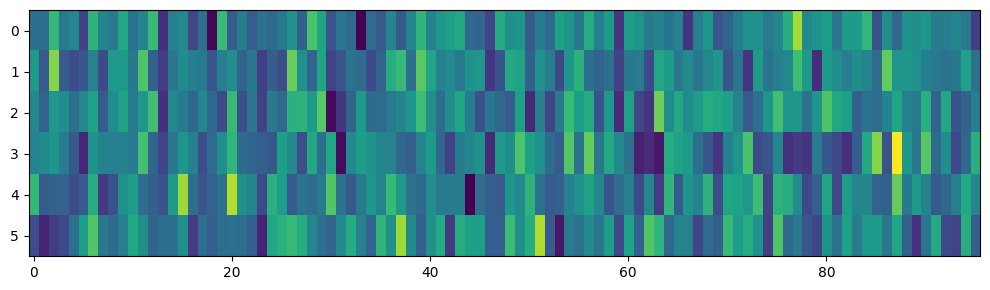

In [58]:
# visualize the embeddings
words = ['pink', 'blue', 'yellow', 'king', 'prince', 'duke']
embedding_matrix = torch.stack([get_embedding(w).cpu().detach() for w in words])

plt.figure(figsize=(10, 3))
plt.imshow(embedding_matrix, cmap='viridis', aspect='auto')
plt.tight_layout()
plt.show()

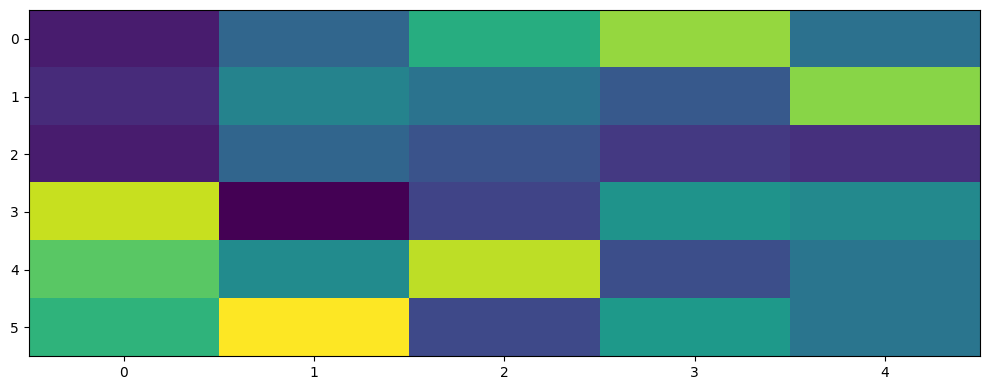

In [63]:
# visualize the embeddings with PCA
words = ['pink', 'blue', 'yellow', 'king', 'prince', 'duke']
embedding_matrix = torch.stack([get_embedding(w).cpu().detach() for w in words])

pca = PCA(n_components=len(words) - 1)
principal_components = pca.fit_transform(embedding_matrix)

plt.figure(figsize=(10, 4))
plt.imshow(principal_components, cmap='viridis', aspect='auto')
plt.tight_layout()
plt.show()

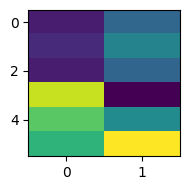

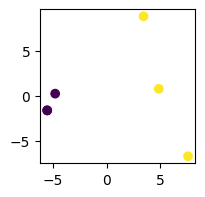

In [70]:
words = ['pink', 'blue', 'yellow', 'king', 'prince', 'duke']
embedding_matrix = torch.stack([get_embedding(w).cpu().detach() for w in words])
colors = torch.tensor([0, 0, 0, 1, 1, 1])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(embedding_matrix)

# we lose a lot of information by projecting to 2D 2 vectors become equal ¯\_(ツ)_/¯
plt.figure(figsize=(2, 2))
plt.imshow(principal_components, cmap='viridis', aspect='auto')
plt.tight_layout()
plt.show()

plt.figure(figsize=(2, 2))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=colors, cmap='viridis')
plt.show()

### Working with lower dimensions

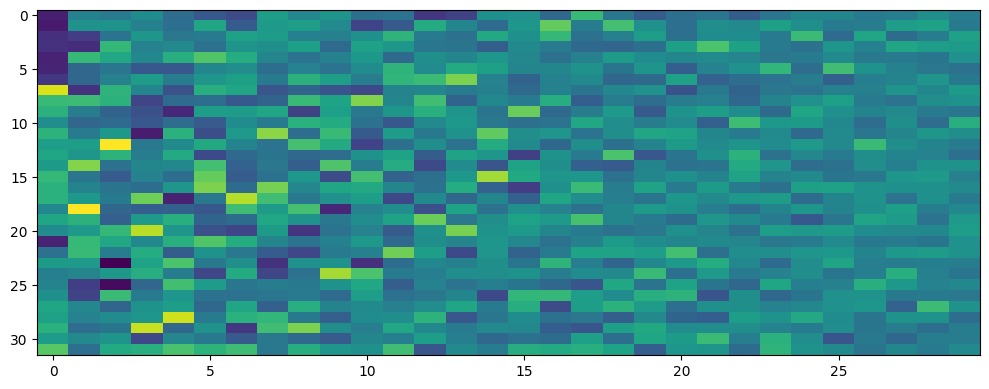

In [108]:
# This is a cool one :D
# notice how the colors get more and more washed toward the right, it's because the PC are ordered by variance
words = words_i_want_to_learn[:]
embedding_matrix = torch.stack([get_embedding(w).cpu().detach() for w in words])

pca = PCA(n_components=len(words) - 2)
# pca = PCA(n_components=5)
principal_components = torch.tensor(pca.fit_transform(embedding_matrix))
w2pc = {w: pc for w, pc in zip(words, principal_components)}
pc2w = {pc: w for w, pc in w2pc.items()}

plt.figure(figsize=(10, 4))
plt.imshow(principal_components, cmap='viridis', aspect='auto')
plt.tight_layout()
plt.show()

In [221]:
# word arithmetic (not gonna work, but let me dream)
# emb_word = get_embedding('king') - get_embedding('man') + get_embedding('woman')
# emb_word = get_embedding('prince') - get_embedding('princess')
emb_word = w2pc['king'] - w2pc['queen']
emb_word = w2pc['king'] - w2pc['man'] + w2pc['woman']
emb_word = w2pc['king'] - w2pc['male'] + w2pc['female']
emb_word = w2pc['king'] - w2pc['prince'] + w2pc['princess']
emb_word = w2pc['prince'] - w2pc['king'] + w2pc['queen']

matches = []
for w in words_i_want_to_learn:
    emb_w = w2pc[w]
    d = cosine_dist(emb_word, emb_w)
    matches.append((d, w))

for d, w in sorted(matches)[:10]:
    print(f'{d:.4f} {w}')

0.3830 queen
0.5380 prince
0.8162 fruit
0.8476 sir
0.8501 female
0.9163 duke
0.9236 cat
0.9325 princess
0.9428 green
0.9656 sheep


### vectorized compute pairwise distances

In [237]:
# compute all embeddings
witos = {i: w for i, w in enumerate(words_i_want_to_learn)}
embds = torch.stack([get_embedding(w) for w in words_i_want_to_learn])
embds.shape

torch.Size([32, 96])

In [234]:
# compute all pairwise distances
def pairwise_euclidean_distance(embds):
    xx = torch.sum(embds**2, dim=1)
    xy = embds @ embds.T
    x2 = xx.view(-1, 1)
    return x2 - 2 * xy + xx

pwed = pairwise_euclidean_distance(embds)
print(pwed.shape)

torch.Size([32, 32])


In [238]:
# Compute the closest word for each other word in the vocab:
#
# This is totally non-sensical :(
# I don't see any pattern in the results 
# hyp 1: the dataset is too sparse, only a few mention of each words
# hyp 2: the model is too small, it's not able to learn anything
# hyp 3: Unknown-unknown, I messed up something
e = pwed
mask = (torch.ones_like(e) * float('inf')).tril()
vals, ind = torch.min((e + mask), dim=1)

for i, j in enumerate(ind[:-1]):
    print(f'{witos[i]} {witos[j.item()]}')

red blue
green orange
blue purple
yellow purple
orange orange
purple pink
pink orange
king sheep
queen sheep
prince princess
princess chicken
duke sheep
lord orange
lady sheep
sir orange
man chicken
woman sheep
male cat
female chicken
fruit chicken
apple cow
orange chicken
banana sheep
dog chicken
cat chicken
horse chicken
cow sheep
chicken sheep
bird sheep
fish elephant
sheep elephant


## compare with a locally trained gensim.word2vec

In [115]:
from gensim.models import Word2Vec

mx2 = Word2Vec(sentences=butchered_sentences2, vector_size=100, window=7, min_count=1, workers=20, epochs=4000)


In [126]:
# save to disk
# mx2.save('gensim-word2vec.wordvectors')

In [151]:
extra_help = [
    'the king is a man',
    'king is male',
    'king was a boy',
    'king will be an old man',
    'prince is a boy',
    'prince will be a man',
    'prince is male',
    'duke is a man',
    'duke was a boy',
    'duke is male',
    'a lord is a man',
    'a lord was a boy',
    'a lord is a male',
    'sir is a man',
    'sir was a boy',
    'sir is a male',

    'queen is a woman',
    'queen is a female',
    'queen was a girl',
    'princess is a girl',
    'princess will be a woman',
    'princess is a female',
    'lady is a woman',
    'lady was a girl',
    'lady is female',

    'the queed married the king',
    'the lady love the lord',
    'tke king love the queen',
    'the prince and princess are siblings',
]

eh = [s.split() for s in extra_help]
butchered_sentences3 = eh + butchered_sentences2

mx3 = Word2Vec(sentences=butchered_sentences3, vector_size=100, window=7, min_count=1, workers=20, epochs=10000)
# mx3.save('gensim-word2vec-help.wordvectors')

In [239]:
for w in words_i_want_to_learn[::4]:
    # related = mx2.wv.most_similar(w)
    related = mx3.wv.most_similar(w)
    print(f'{w}')
    for rw, rd in related[:3]:
        print(f'  {rw}, {rd:.4f}')

red
  blue, 0.7398
  green, 0.7189
  man, 0.6805
orange
  green, 0.5566
  fish, 0.4576
  red, 0.4547
queen
  king, 0.7274
  lady, 0.6459
  lord, 0.6236
lord
  king, 0.7849
  man, 0.7441
  prince, 0.6524
woman
  man, 0.7913
  male, 0.6994
  female, 0.6992
apple
  fruit, 0.5903
  female, 0.5862
  fish, 0.5751
cat
  sheep, 0.6451
  female, 0.6441
  fish, 0.6273
bird
  man, 0.6414
  red, 0.6393
  cat, 0.6021


In [240]:
# failing at word arithmetic again but this time it cannot be my model's fault :D
def scope(mx=mx2):
    res = mx.wv.similar_by_vector(mx.wv['king'] - mx.wv['man'] + mx.wv['woman'], topn=3)
    print(res)

scope(mx3)

[('woman', 0.8453487753868103), ('king', 0.7691278457641602), ('prince', 0.6501697301864624)]


## compare with pre-trained gensim

In [199]:
import gensim.downloader

In [241]:
# still failing at word arithmetic, but this time it's not my model, not my dataset, it's the whole world that is wrong ¯\_(ツ)_/¯
glove_vectors = gensim.downloader.load('word2vec-google-news-300') # 1.6 GB
# glove_vectors = gensim.downloader.load('glove-twitter-25')       # 100 MB

e = glove_vectors['king'] - glove_vectors['prince'] + glove_vectors['princess']
e = glove_vectors['king'] - glove_vectors['man'] + glove_vectors['woman']
e = glove_vectors['france'] - glove_vectors['paris'] + glove_vectors['london']
e = glove_vectors['paris'] - glove_vectors['france'] + glove_vectors['uk']
e = glove_vectors['paris'] - glove_vectors['france'] + glove_vectors['germany']

glove_vectors.similar_by_vector(e, topn=10)

[('paris', 0.7316325902938843),
 ('germany', 0.6952009797096252),
 ('berlin', 0.48383620381355286),
 ('german', 0.4694601595401764),
 ('lindsay_lohan', 0.4535733461380005),
 ('switzerland', 0.4468131363391876),
 ('heidi', 0.44448140263557434),
 ('lil_kim', 0.43990591168403625),
 ('las_vegas', 0.43985921144485474),
 ('russia', 0.4398398697376251)]

## compare with a pre-trained BERT

In [157]:
from transformers import BertModel, BertTokenizer

In [243]:
# Load pre-trained model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

In [244]:
def get_bert_embedding(word):
    tokens = tokenizer(word, return_tensors='pt')
    token_id = tokens['input_ids'][0][1].item()
    embeddings_layer = model.get_input_embeddings()
    return embeddings_layer(torch.tensor([[token_id]])).view(-1)

def get_bert_embedding_deeper(word):
    tokens = tokenizer(word, return_tensors='pt')
    token_id = tokens['input_ids'][0][1].item()
    with torch.no_grad():
        outputs = model(torch.tensor([[token_id]]))
    return outputs.last_hidden_state.view(-1)

# word_embeddings = get_bert_embedding('king')
word_embeddings = get_bert_embedding_deeper('king')
word_embeddings.shape

torch.Size([768])

In [246]:
# one more word arithmetic attempt
bw2e = {w: get_bert_embedding(w) for w in words_i_want_to_learn}
# bw2e = {w: get_bert_embedding_deeper(w) for w in words_i_want_to_learn}

emb_word = bw2e['king'] - bw2e['man'] + bw2e['woman']

matches = []
for w in words_i_want_to_learn:
    emb_w = bw2e[w]
    d = cosine_dist(emb_word, emb_w)
    matches.append((d, w))

for d, w in sorted(matches)[:10]:
    print(f'{d:.4f} {w}')

0.2630 king
0.3531 queen
0.5115 woman
0.5248 princess
0.5540 female
0.5956 prince
0.6266 lady
0.6393 duke
0.6689 lord
0.7145 bird
